# TF-IDF score: Kullback–Leibler divergence

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore
from scipy.stats import fit, exponnorm, gaussian_kde

import configuration as config
import functions.notebook_helper as helper_funcs

/mnt/arkk/llm_detector/classifier


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/siderealyear/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/siderealyear/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load the training data from the last step with the perpleixty ratio KL score already added.

In [2]:
with open(config.FEATURE_ENGINEERING_CLASS_INSTANCE, 'rb') as file:
    data = pickle.load(file)

Clean up the text fragments for TF-IDF analysis.

In [3]:
# Take samples so we don't OOM during vectorization for TF-IDF
training_data_df_sample = data.training.all.combined.sample(frac = 0.5, random_state = 42)
training_data_df_sample.reset_index(inplace = True, drop = True)

In [4]:
# Get human and synthetic text
human_texts_sample = training_data_df_sample['String'][training_data_df_sample['Source'] == 'human']
synthetic_texts_sample = training_data_df_sample['String'][training_data_df_sample['Source'] == 'synthetic']

In [5]:
# Clean for vectorization
human_texts_sample = human_texts_sample.apply(lambda x: helper_funcs.clean_text(x))
synthetic_texts_sample = synthetic_texts_sample.apply(lambda x: helper_funcs.clean_text(x))

Now calculate TF-IDF on the human and synthetic text samples.

In [6]:
# Fit the TF-IDF vectorizer
human_tfidf_vectorizer = TfidfVectorizer()
human_tfidf_vectors = human_tfidf_vectorizer.fit_transform(human_texts_sample)

# Convert the vectors to numpy and replace zeros with NAN
human_tfidf = human_tfidf_vectors.toarray()
human_tfidf[human_tfidf == 0] = np.nan

# Take the log2 and average the columns (i.e. get average TF-IDF per word)
log_human_tfidf = np.log2(human_tfidf)
log_human_tfidf_mean = np.nanmean(log_human_tfidf, axis = 0)

# Get the words
human_features = human_tfidf_vectorizer.get_feature_names_out()


In [7]:
# Release some memory
del human_tfidf_vectorizer
del human_tfidf_vectors
_ = gc.collect()

In [8]:
# Fit the TF-IDF vectorizer
synthetic_tfidf_vectorizer = TfidfVectorizer() 
synthetic_tfidf_vectors = synthetic_tfidf_vectorizer.fit_transform(synthetic_texts_sample)

# Convert the vectors to numpy and replace zeros with NAN
synthetic_tfidf = synthetic_tfidf_vectors.toarray()
synthetic_tfidf[synthetic_tfidf == 0] = np.nan

# Take the log2 and average the columns (i.e. get average TF-IDF per word)
log_synthetic_tfidf = np.log2(synthetic_tfidf)
log_synthetic_tfidf_mean = np.nanmean(log_synthetic_tfidf, axis = 0)

# Get the words
synthetic_features = synthetic_tfidf_vectorizer.get_feature_names_out()

In [9]:
# Release some memory
del synthetic_tfidf_vectorizer
del synthetic_tfidf_vectors
_ = gc.collect()

In [10]:
# Make the look-up tables
tfidf_luts = {
    'human': dict(zip(human_features, log_human_tfidf_mean)),
    'synthetic': dict(zip(synthetic_features, log_synthetic_tfidf_mean))
}

In [11]:
# Score the text fragments
fragment_scores = helper_funcs.score_known_text_fragments(data.training.all.combined, tfidf_luts)

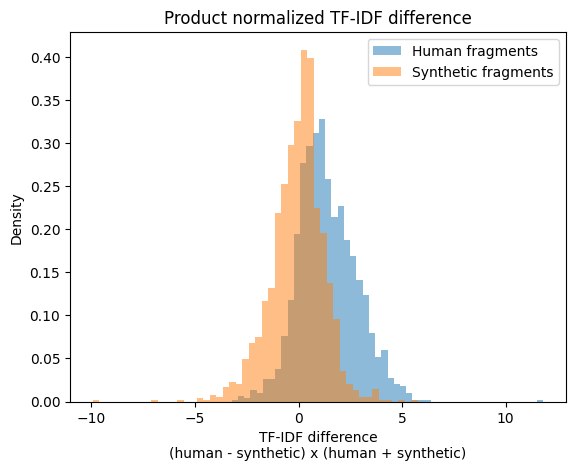

In [12]:
plt.title('Product normalized TF-IDF difference')
plt.hist(fragment_scores['human'], density = True, bins = 50, label = 'Human fragments', alpha = 0.5)
plt.hist(fragment_scores['synthetic'], density = True, bins = 50, label = 'Synthetic fragments', alpha = 0.5)
plt.xlabel('TF-IDF difference\n(human - synthetic) x (human + synthetic)')
plt.ylabel('Density')
plt.legend(loc = 'upper right')
plt.show()

In [13]:
# Set up bins for the combined dataset
product_normalized_dtfidfs = []
product_normalized_dtfidfs.extend(fragment_scores['human'])
product_normalized_dtfidfs.extend(fragment_scores['synthetic'])

counts, bins = np.histogram(product_normalized_dtfidfs, bins = 100, density = True)

# Get bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms for the human and synthetic data
human_density, human_bins = np.histogram(fragment_scores['human'], bins = bins, density = True)
synthetic_density, synthetic_bins = np.histogram(fragment_scores['synthetic'], bins = bins, density = True)

Now, fit the individual distributions with an exponential Gaussian:

In [14]:
# Set parameter bounds
bounds = [[-10.0,10.0],[-10.0,10.0],[-10.0,10.0]]

# Do the fits
human_fit = fit(exponnorm, fragment_scores['human'], bounds = bounds)
synthetic_fit = fit(exponnorm, fragment_scores['synthetic'], bounds = bounds)

# Construct functions from each fit
human_exponnorm = exponnorm(human_fit.params.K, human_fit.params.loc, human_fit.params.scale)
synthetic_exponnorm = exponnorm(synthetic_fit.params.K, synthetic_fit.params.loc, synthetic_fit.params.scale)

# Get fitted values for the histogram bin centers
human_fitted_values = human_exponnorm.pdf(bin_centers)
synthetic_fitted_values = synthetic_exponnorm.pdf(bin_centers)

/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)
/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1782: RuntimeWarning: overflow encountered in scalar divide
  invK = 1.0 / K


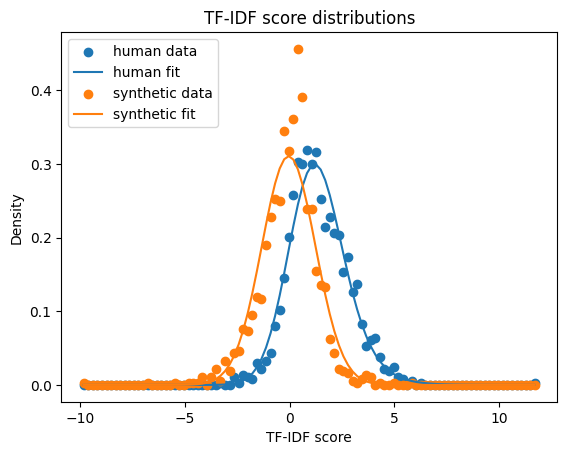

In [15]:
# Plot as scatter
plt.scatter(bin_centers, human_density, label = 'human data')
plt.plot(bin_centers, human_fitted_values, label = 'human fit')
plt.scatter(bin_centers, synthetic_density, label = 'synthetic data')
plt.plot(bin_centers, synthetic_fitted_values, label = 'synthetic fit')

plt.title('TF-IDF score distributions')
plt.xlabel('TF-IDF score')
plt.ylabel('Density')
plt.legend(loc = 'upper left')
plt.show()

Ok, looks good to me - let's take a closer look at the fits.

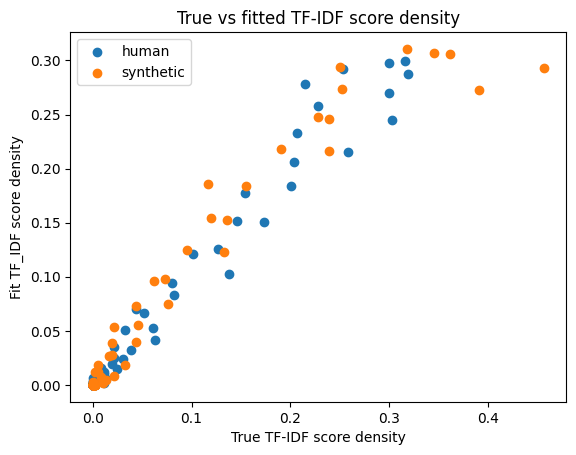

In [16]:
plt.title('True vs fitted TF-IDF score density')
plt.scatter(human_density, human_fitted_values, label = 'human')
plt.scatter(synthetic_density, synthetic_fitted_values, label = 'synthetic')
plt.legend(loc = 'upper left')
plt.xlabel('True TF-IDF score density')
plt.ylabel('Fit TF-IDF score density')
plt.show()

OK, looks good enough to me - now let's take a look at the Kullback-Leibler divergence of the two fits.

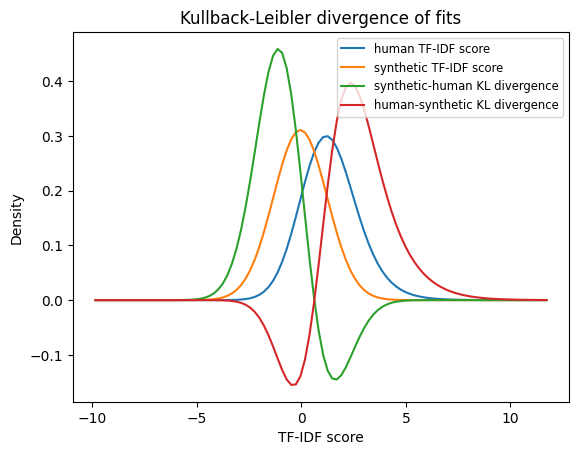

In [19]:
plt.title('Kullback-Leibler divergence of fits')
plt.plot(bin_centers, human_fitted_values, label = 'human TF-IDF score')
plt.plot(bin_centers, synthetic_fitted_values, label = 'synthetic TF-IDF score')
plt.plot(bin_centers, helper_funcs.kl_divergence(synthetic_fitted_values, human_fitted_values), label = 'synthetic-human KL divergence')
plt.plot(bin_centers, helper_funcs.kl_divergence(human_fitted_values, synthetic_fitted_values), label = 'human-synthetic KL divergence')
plt.xlabel('TF-IDF score')
plt.ylabel('Density')
plt.legend(loc = 'upper right', fontsize = 'small')
plt.show()

Sweet - I think we got it! Now, similarly to how we handled perplexity ratio score, we need a probability density function for the Kullback-Leibler divergence distribution. To do that - we need a kernel density estimate, and to do that - we need to reconstruct KL scores that would give the observed distribution.

In [ ]:
# Get a kernel density estimate of the KL divergence so we can use the
# associated probability density function to convert perplexity ratio scores
# into KL scores

# Get a list of points covering the range of score values
tfidf_scores = fragment_scores['human'] + fragment_scores['synthetic']
x = np.arange(min(tfidf_scores) - 2, max(tfidf_scores) + 2, 0.01).tolist()
print(f'Will calculate {len(x)} fitted values')

# Do the exponential gaussian fits and get values for f(x)
bounds = [[-10.0,10.0],[-10.0,10.0],[-10.0,10.0]]

human_exponnorm = fit(exponnorm, fragment_scores['human'], bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(x)

synthetic_exponnorm = fit(exponnorm, fragment_scores['synthetic'], bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(x)

# Calculate the KL divergence of the fitted values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)

print(f'Have {len(kl)} KL divergence values')

In [ ]:
# Convert the kl 'density' values into integer 'count' values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)
kl = kl + abs(min(kl))
kl = kl * 100
kl_counts = [int(density) for density in kl]

print(f'Min KL count value {min(kl_counts)}')
print(f'Max KL count value: {max(kl_counts)}')

# Now, construct a list where each value of x appears a number of times
# equal to it's kl 'count'
kl_scores = []

for i in range(len(kl_counts)):
    kl_scores.extend([x[i]] * kl_counts[i])

# Finally, run a KDE on the reconstructed KL scores
kl_kde = gaussian_kde(kl_scores)

# And use it's PDF to get density for x after re-clipping x to the
# range of the original data
clipped_x = []
clipped_kl = []
clipped_kl_counts = []

for i, j in enumerate(x):
    if j > min(tfidf_scores) and j < max(tfidf_scores):
        clipped_x.append(j)
        clipped_kl.append(kl[i])
        clipped_kl_counts.append(kl_counts[i])

clipped_kl_kde_values = kl_kde.pdf(clipped_x)

fig, axs = plt.subplots(
    2,
    2,
    figsize = (7, 7),
    gridspec_kw = {'wspace':0.4, 'hspace':0.3}
)

axs[0,0].set_title('KL divergence density')
axs[0,0].scatter(clipped_x, clipped_kl, color='black', s = 1)
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Density')

axs[0,1].set_title('KL divergence counts')
axs[0,1].scatter(clipped_x, clipped_kl_counts, color='black', s = 1)
axs[0,1].set_xlabel('Perplexity ratio score')
axs[0,1].set_ylabel('Count')

axs[1,0].set_title('KL score counts')
axs[1,0].hist(kl_scores, bins = 50, color='black', density = True)
axs[1,0].set_xlabel('Perplexity ratio score')
axs[1,0].set_ylabel('Count')

axs[1,1].set_title('KL KDE')
axs[1,1].scatter(clipped_x, clipped_kl_kde_values, color='black', s = 1)
axs[1,1].set_xlabel('Perplexity ratio score')
axs[1,1].set_ylabel('Count')

plt.show()

OK, cool. Looks good. Now we need to TF-IDF score the fragments from the Hans 2024 corpus, and run the scores though the KL KDE's PDF and add the result to the dataframe.

In [ ]:
def score_text_fragments(data_df: pd.DataFrame, tfidf_luts: dict = None) -> dict:
    '''Scores text fragments, returns human and synthetic TF-IDF and product 
    normalized difference in log2 TF-IDF mean'''

    # Holders for new features
    tfidf_scores = []
    human_tfidf = []
    synthetic_tfidf = []

    # Loop on dataframe rows
    for _, row in data_df.iterrows():
        
        human_tfidf_sum = 0
        synthetic_tfidf_sum = 0

        # Get the text from this row
        text = row['String']

        # Clean the text
        text = clean_text(text)

        # Split the text into words
        words = text.split(' ')

        # Score the words using the human and synthetic luts
        for word in words:

            if word in tfidf_luts['human'].keys():
                human_tfidf_sum += tfidf_luts['human'][word]

            if word in tfidf_luts['synthetic'].keys():
                synthetic_tfidf_sum += tfidf_luts['synthetic'][word]

        # Get the means
        human_tfidf_mean = human_tfidf_sum / len(words)
        synthetic_tfidf_mean = synthetic_tfidf_sum / len(words)
        dmean_tfidf = human_tfidf_mean - synthetic_tfidf_mean
        product_normalized_dmean_tfidf = dmean_tfidf * (human_tfidf_mean + synthetic_tfidf_mean)

        human_tfidf.append(human_tfidf_mean)
        synthetic_tfidf.append(synthetic_tfidf_mean)
        tfidf_scores.append(product_normalized_dmean_tfidf)

    return {'human_tfidf': human_tfidf, 'synthetic_tfidf': synthetic_tfidf, 'tfidf_score': tfidf_scores}

In [ ]:
# Score the training fragments and add new features back to dataframe
fragment_scores = score_text_fragments(training_data_df, tfidf_luts)

training_data_df['Human TF-IDF'] = fragment_scores['human_tfidf']
training_data_df['Synthetic TF-IDF'] = fragment_scores['synthetic_tfidf']
training_data_df['TF-IDF score'] = fragment_scores['tfidf_score']

In [ ]:
# Get KL score and add to dataframe
kl_scores = kl_kde.pdf(fragment_scores['tfidf_score'])
training_data_df['TF-IDF Kullback-Leibler score'] = kl_scores

training_data_df.head()
print()
training_data_df.info()

Re-plot just to be sure we got the result we expected:

In [ ]:
plt.title('Kullback-Leibler score as a function of TF-IDF score')
plt.scatter(training_data_df['TF-IDF score'], training_data_df['TF-IDF Kullback-Leibler score'], color = 'black', s = 1)
plt.xlabel('TF-IDF score')
plt.ylabel('Kullback-Leibler score')
plt.show()

Nailed it! Save for the next step.

In [ ]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA_PR_TFIDF

with open(output_file, 'w') as file:
    file.write(training_data_df.to_json())

Now do the same thing with the testing data, using the KL PDF derived from the training data.

In [ ]:
# Load the data testing data
testing_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TESTING_DATA_PR)

# Replace and remove string 'OOM' and 'NAN' values
testing_data_df.replace('NAN', np.nan, inplace = True)
testing_data_df.replace('OOM', np.nan, inplace = True)
testing_data_df.dropna(inplace = True)

# Fix some d-types
testing_data_df = testing_data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

fragment_scores = score_text_fragments(testing_data_df, tfidf_luts)

testing_data_df['Human TF-IDF'] = fragment_scores['human_tfidf']
testing_data_df['Synthetic TF-IDF'] = fragment_scores['synthetic_tfidf']
testing_data_df['TF-IDF score'] = fragment_scores['tfidf_score']

# Get KL score and add to dataframe
kl_scores = kl_kde.pdf(fragment_scores['tfidf_score'])
testing_data_df['TF-IDF Kullback-Leibler score'] = kl_scores

output_file = config.COMBINED_SCORED_HANS_TESTING_DATA_PR_TFIDF

with open(output_file, 'w') as file:
    file.write(testing_data_df.to_json())

testing_data_df.info()

Finally, save the Kullback–Leibler kernel density estimate for future use.

In [ ]:
from pickle import dump

output_file = config.TFIDF_KL_KDE

with open(output_file, 'wb') as file:
    dump(kl_kde, file, protocol = 5)